In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import os
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score

from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model


# Load the GearBox data

In [2]:
import load_data

pth1 = 'data/BrokenTooth'
pth2 = 'data/Healthy'
window_len = 300  # How many window_len as 1 feature point 
inference_data_point = 5 # This value should be considered the MCU rom size. 5*300*10*2 = 30000 float points

broken_df_train, broken_df_test  = load_data.create_test_train_df_fromRaw(pth1 , 1, 
                                    inference_data_point, window_len, (load_data.addCol_load, load_data.addCol_fault))        
healthy_df_train, healthy_df_test = load_data.create_test_train_df_fromRaw(pth2 , 0, 
                                    inference_data_point, window_len, (load_data.addCol_load, load_data.addCol_fault))

In [3]:
broken_df_test
#broken_df_train

,a1,a2,a3,a4,load,fault
0,2.350390,1.454870,-1.667080,-2.055610,0.0,1.0
1,2.452970,1.400100,-2.825100,0.984487,0.0,1.0
2,-0.241284,-0.267390,0.793540,0.605862,0.0,1.0
3,1.130270,-0.890918,0.696969,0.613068,0.0,1.0
4,-1.296140,0.980479,-1.130560,-0.346971,0.0,1.0
...,...,...,...,...,...,...
14995,-3.443520,-0.361539,-0.376093,-2.447550,90.0,1.0
14996,2.458310,-2.838840,0.191190,-0.201169,90.0,1.0
14997,-0.755909,3.982960,-2.321580,0.749357,90.0,1.0
14998,1.299520,4.402300,-2.232460,0.535038,90.0,1.0


# Feature Process

In [4]:
import feature_process

# Calculate the windows size features, combine 300 data as 1 points. 
Data_healthy, Lable_healthy = feature_process.window_feature_autoencoder(healthy_df_train, 0, window_len, 4, 16)#200 =>0.87% #300 => 90%~92%(batch_size=256), #400 => 90%~92%(batch_size=128), #500 => 93%(batch_size=64)
Data_broken, Lable_broken = feature_process.window_feature_autoencoder(broken_df_train, 1, window_len, 4, 16)
print("feature array shape of healthy point: {}, {}".format(Data_healthy.shape, Lable_healthy.shape))
print("feature array shape of broken point: {}, {}".format(Data_broken.shape, Lable_broken.shape))

feature array shape of healthy point: (3336, 16), (3336,)
feature array shape of broken point: (3301, 16), (3301,)


In [5]:
# Create the random 80% train and 20% test
train_data, test_data, train_labels, test_labels = feature_process.concatenate_data(Data_healthy,Data_broken,Lable_healthy,Lable_broken, 0.1, 21)
print("train data shape: {}, {}".format(train_data.shape, train_labels.shape))
print("test data shape: {}, {}".format(test_data.shape, test_labels.shape))
#print(test_data)
# save the max&min val
max_val = tf.reduce_max(train_data)
min_val = tf.reduce_min(train_data)

train data shape: (5973, 16), (5973,)
test data shape: (664, 16), (664,)


# Autoencoder

## Autoencoder data prepare
- Need to normalize the data
- Need to sperate the data into normal and anomalous set

In [6]:
# normalize
train_data, test_data = feature_process.normalize_data_maxmin(train_data, test_data)
print(type(train_data))

# sperate to True & False for Autoencoder
normal_train_data, anomalous_train_data = feature_process.normal_anomalous_distb(train_data, train_labels)
normal_test_data, anomalous_test_data = feature_process.normal_anomalous_distb(test_data, test_labels)
print("anomalous train data set: {}".format(anomalous_train_data.shape))
print("normal train data set: {}".format(normal_train_data.shape))

tf.Tensor(3158.1043774, shape=(), dtype=float64) tf.Tensor(-0.619863934954322, shape=(), dtype=float64)
<class 'tensorflow.python.framework.ops.EagerTensor'>
anomalous train data set: (3012, 16)
normal train data set: (2961, 16)


## Autoencoder Training

In [15]:
def create_autoencoder(sample_shape):
    #sample_shape = normal_train_data[0].shape
    
    model = tf.keras.Sequential([
        layers.InputLayer(input_shape=sample_shape),
        layers.Dense(8, activation="relu"),
        layers.Dense(4, activation="relu"),
        layers.Dense(4, activation="relu"),
        layers.Dense(8, activation="relu"),
        layers.Dense(*sample_shape, activation='sigmoid')
    ])
    
    # Display model
    model.summary()
    model.compile(optimizer='adam', loss='mae')
    return model
Autoen_model = create_autoencoder(normal_train_data[0].shape)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 8)                 136       
                                                                 
 dense_11 (Dense)            (None, 4)                 36        
                                                                 
 dense_12 (Dense)            (None, 4)                 20        
                                                                 
 dense_13 (Dense)            (None, 8)                 40        
                                                                 
 dense_14 (Dense)            (None, 16)                144       
                                                                 
Total params: 376
Trainable params: 376
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Train model (note Y labels are same as inputs, X)
def train_autoencoder(m_epochs, m_batch_size, normal_train_data, normal_test_data, ):
    history = Autoen_model.fit(normal_train_data, normal_train_data,
                               epochs=m_epochs,
                               batch_size=m_batch_size,
                               validation_data=(normal_test_data, normal_test_data), 
                               shuffle=True)
    return history
history = train_autoencoder(300, 128, normal_train_data, normal_test_data)

Epoch 1/300
24/24 [==============================] - 0s 6ms/step - loss: 0.4186 - val_loss: 0.4139
Epoch 2/300
24/24 [==============================] - 0s 2ms/step - loss: 0.4090 - val_loss: 0.4002
Epoch 3/300
24/24 [==============================] - 0s 2ms/step - loss: 0.3894 - val_loss: 0.3726
Epoch 4/300
24/24 [==============================] - 0s 2ms/step - loss: 0.3532 - val_loss: 0.3255
Epoch 5/300
24/24 [==============================] - 0s 2ms/step - loss: 0.2948 - val_loss: 0.2547
Epoch 6/300
24/24 [==============================] - 0s 2ms/step - loss: 0.2185 - val_loss: 0.1761
Epoch 7/300
24/24 [==============================] - 0s 2ms/step - loss: 0.1417 - val_loss: 0.1044
Epoch 8/300
24/24 [==============================] - 0s 2ms/step - loss: 0.0787 - val_loss: 0.0539
Epoch 9/300
24/24 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0308
Epoch 10/300
24/24 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.0225
Epoch 11/

## Show the loss and decide threshold

95/95 [==============================] - 0s 1ms/step


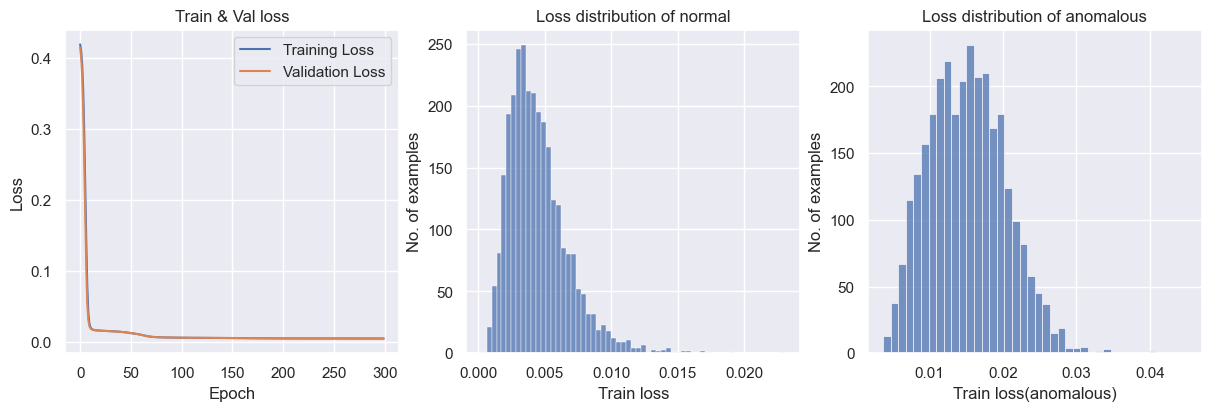

Threshold:  0.0068370393


In [17]:
def result_autoencoder(model_autoen, history_autoen, normal_data, anomalous_data):

    sns.set(style="darkgrid")  # darkgrid, whitegrid, dark, white, ticks
    fig, ax =plt.subplots(1,3,constrained_layout=True, figsize=(12, 4))
    
    axesSub = sns.lineplot(data = history_autoen.history["loss"], ci = None, label="Training Loss", ax=ax[0])
    axesSub = sns.lineplot(data = history_autoen.history["val_loss"], ci = None, label="Validation Loss", ax=ax[0])
    axesSub.set_xlabel('Epoch')
    axesSub.set_ylabel('Loss')
    axesSub.set_title('Train & Val loss')
    
    # For finding threshold to fault detection, histogram, of train loss and test loss was plotted
    reconstructions = model_autoen.predict(normal_data)
    train_loss = tf.keras.losses.mae(reconstructions, normal_data)
    train_loss = np.array(train_loss) #convert to np.array
    axesSub = sns.histplot(data=train_loss, ax=ax[1])
    axesSub.set_xlabel('Train loss')
    axesSub.set_ylabel('No. of examples')
    axesSub.set_title('Loss distribution of normal')
    
    reconstructions = model_autoen.predict(anomalous_data)
    test_loss = tf.keras.losses.mae(reconstructions, anomalous_data)
    #test_loss = tf.keras.losses.mse(reconstructions, anomalous_data)
    test_loss = np.array(test_loss) #convert to np.array
    axesSub = sns.histplot(data=test_loss, ax=ax[2])
    axesSub.set_xlabel('Train loss(anomalous)')
    axesSub.set_ylabel('No. of examples')
    axesSub.set_title('Loss distribution of anomalous')
    
    plt.show()
    
    # threshold for fault detection based on model error
    threshold = np.mean(train_loss) + np.std(train_loss)
    print("Threshold: ", threshold)
    return threshold

threshold = result_autoencoder(Autoen_model, history, normal_train_data, anomalous_train_data)

## Test Result

In [18]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    #loss = tf.keras.losses.mse(reconstructions, data)  
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))
    
# accuracy
print("Test Data number: {}".format(test_data.shape[0]))
preds = predict(Autoen_model, test_data, threshold)
print_stats(preds, test_labels)

print("Train Data number: {}".format(train_data.shape[0]))
preds = predict(Autoen_model, train_data, threshold)
print_stats(preds, train_labels)

# accuracy for 

Test Data number: 664
Accuracy = 0.9126506024096386
Precision = 0.9638157894736842
Recall = 0.861764705882353
Train Data number: 5973
Accuracy = 0.9090909090909091
Precision = 0.9524700598802395
Recall = 0.8595069233367105


## Show MCU Inference Result first
- This dataset is for MCU inference latter, and we use PC python to inference first.
- The `Accuracy` value should be almost same as MCU result latter.  

In [ ]:
# accuracy for MCU inference data

# calculate feature
Data_healthy_test, Lable_healthy_test = feature_process.window_feature_autoencoder(healthy_df_test, 0, window_len, 4, 16)#200 =>0.87% #300 => 90%~92%(batch_size=256), #400 => 90%~92%(batch_size=128), #500 => 93%(batch_size=64)
Data_broken_test, Lable_broken_test = feature_process.window_feature_autoencoder(broken_df_test, 1, window_len, 4, 16)
print("feature array shape of test healthy point: {}, {}".format(Data_healthy_test.shape, Lable_healthy_test.shape))
print("feature array shape of test broken point: {}, {}".format(Data_broken_test.shape, Lable_broken_test.shape))
inference_data = np.concatenate([Data_healthy_test, Data_broken_test], axis =0)
inference_label = np.concatenate([Lable_healthy_test, Lable_broken_test], axis =0)

# normalize
# min_val = tf.reduce_min(inference_data)
# max_val = tf.reduce_max(inference_data)
print(max_val, min_val)
inference_data = (inference_data - min_val) / (max_val - min_val)
inference_data = tf.cast(inference_data, tf.float32)

print("Test Data number: {}".format(inference_data.shape[0]))
preds = predict(Autoen_model, inference_data, threshold)
print_stats(preds, inference_label)

feature array shape of test healthy point: (50, 16), (50,)
feature array shape of test broken point: (50, 16), (50,)
tf.Tensor(3158.1043774, shape=(), dtype=float64) tf.Tensor(-0.619863934954322, shape=(), dtype=float64)
Test Data number: 100
Accuracy = 0.95
Precision = 0.9591836734693877
Recall = 0.94


# TensorFlow Lite Conversion

In [21]:
# If we're happy with the performance, save the model
ori_model = Autoen_model
keras_model_name = 'autoencoder'

tf.saved_model.save(ori_model, keras_model_name)

INFO:tensorflow:Assets written to: autoencoder\assets


In [22]:
# Convert Keras model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(ori_model)
tflite_model = converter.convert()
open(keras_model_name + '.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\CYCHEN38\AppData\Local\Temp\tmpw5qwiyec\assets


4380

In [23]:
def tflite_to_tflu(models_path, c_model_name, keras_model_name, threshold, maxV, minV):
    
    tflite_name = (keras_model_name + '.tflite')
    my_f_name = (os.path.join(models_path, c_model_name) + '.cc')
    ! python tflite_to_tflu_para.py --tflite_path $tflite_name --output_path $my_f_name --window_size_sample $window_len --max_val_train $maxV --min_val_train $minV --threshold_val $threshold

models_path = 'model'
c_model_name = r'Gearbox_fault_' + keras_model_name    
tflite_to_tflu(models_path, c_model_name, keras_model_name, threshold, max_val.numpy(), min_val.numpy())    

# Convert the test data to C code
- This data set is after preprocessed.
- Just used to make sure the model is ok.

In [53]:
import c_writer
how_many_test = test_data.shape[0]

Xtest = test_data.numpy()[:how_many_test,:]  ##transfer to nparray
#print(c_writer.create_array(Xtest,"float","X_test"))
Xtest_str = c_writer.create_array(Xtest,"float","X_test")

ytest = test_labels[:how_many_test].astype(int)
ytest_str = c_writer.create_array(ytest,"uint8_t","y_test")

test_d = Xtest_str + ytest_str

header_test_d = c_writer.create_header(test_d, "gearbox_test_data")
with open( os.path.join("data", "gearbox_test_data") + '.h', 'w') as file:
    file.write(header_test_d)

# Convert the raw data to C code
- This data is raw data, for edge device to inference.
- It is a more realistic case.

In [25]:
import c_writer
def save_test_data_inC(data_X , label_y):
  
    Xtest = data_X
    Xtest_str = c_writer.create_array(Xtest,"float","X_test", 1)
    
    ytest = label_y.astype(int)
    ytest_str = c_writer.create_array(ytest,"uint8_t","y_test")
    
    test_d = Xtest_str + ytest_str
    
    header_test_d = c_writer.create_header(test_d, "gearbox_raw_test_data")
    with open( os.path.join("data", "gearbox_raw_test_data") + '.h', 'w') as file:
        file.write(header_test_d)

raw_data = np.concatenate([healthy_df_test, broken_df_test], axis =0)
raw_label = np.concatenate([Lable_healthy_test, Lable_broken_test], axis =0)
print("The raw data size is: {}".format(len(raw_data)))
print("The raw label size is: {}".format(len(raw_label)))
save_test_data_inC(raw_data[:,0:4], raw_label)        

The raw data size is: 30000
The raw label size is: 100
